In [1]:
import rasterio as rio
import matplotlib.pyplot as plt
import rasterio.warp as warp
import rasterio.plot as rioPlt

In [2]:
s_orig = rio.open('../processedData/tifs/Subset2_S1B_IW_GRDH_1SDH_20190705T101603_20190705T101628_016997_01FFAC_C4BC_Orb_NR_Cal_Spk_TC_dB.tif')
s_graph = rio.open('../processedData/tifs/Subset_S1B_IW_GRDH_1SDH_20190705T101603_20190705T101628_016997_01FFAC_C4BC_Orb_NR_Cal_Spk_TC_dB.tif')
s_gpt = rio.open('../processedData/tifs/Subset2_S1B_IW_GRDH_1SDH_20190705T101603_20190705T101628_016997_01FFAC_C4BC_Orb_NR_Cal_Spk_TC_dB_tryGraph.tif')

In [ ]:
array_orig_firstBand = s_orig.read(1)
array_orig_firstBand.shape

In [ ]:
plt.imshow(array_orig_firstBand, cmap='pink')


In [3]:
test = rio.open('../test_qgis/reprojected_graph.tif')

In [4]:
test.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 20299,
 'height': 6458,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00022199647842756877, 0.0, -55.85755860089086,
        0.0, -0.00022199647842756877, 70.47202406190554)}

In [5]:
array = test.read(1)
array.shape

(6458, 20299)

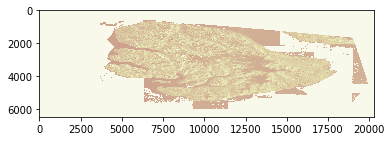

In [6]:
plt.imshow(array, cmap='pink')

In [ ]:
rioPlt.show_hist(array)

/home/rus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/rus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [ ]:
plt.hist(array)
plt.show()

In [ ]:
array_orig_firstBand.shape

In [ ]:
type(s_orig)

In [ ]:
s_orig_reproj = warp.reproject(rio.band(s_orig,1), src_crs=rio.crs.CRS.from_epsg('3413'), dst_crs=rio.crs.CRS.from_epsg('4326'))

In [ ]:
s_orig_reproj[0][0][0]

In [ ]:
plt.imshow(s_orig_reproj[0][0], cmap='pink')

In [ ]:
rioPlt.show((s_orig, 1), cmap='pink')

In [ ]:
plt.plot?

In [ ]:
plt.imshow?

In [3]:
#import rsgislib
#from rsgislib import imageutils
from osgeo import gdal
import numpy
import glob
import sys
from sklearn.cluster import MiniBatchKMeans

ImportError: dlopen(/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/osgeo/_gdal.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libssl.1.0.0.dylib
  Referenced from: /Users/GalinaJonat/anaconda/lib/libgdal.20.dylib
  Reason: image not found

In [3]:
# Search current directory for KEA rasters
InputImages = glob.glob('/Volumes/ElementsSE/thesisData/sigma0/WinsvoldGRD_Sigma0_Subset_Orb_TN_Cal__S1B_IW_GRDH_1SDH_20190412T101559_20190412T101624_015772_01D9A6_29DC.data/Sigma0_HH_db.img')

# Define the number of spectral classes
SpectralClasses = 6

# Define format and datatype of output raster
gdalformat = 'TIF'
gdaldatatype = gdal.GDT_Byte

# Define the classifier
clf = MiniBatchKMeans(n_clusters=SpectralClasses, init='k-means++', max_iter=10, batch_size=10000, verbose=0, compute_labels=True, random_state=None, tol=0.0, max_no_improvement=100, init_size=2000, n_init=10, reassignment_ratio=0.05)

# Terminate the script if the returned list is empty
if not InputImages:
  sys.exit("Error: No input images provided.")

for Raster in sorted(InputImages):
    OutImage = Raster.replace('.img','_Kmeans.img')

    print("Reading " + Raster)
    Image = gdal.Open(Raster, gdal.GA_ReadOnly)

    # Set up empty list to hold data
    TestData = []

    # Read data from each band
    for band in range(Image.RasterCount):
        band += 1

        B = Image.GetRasterBand(band)

        Array = B.ReadAsArray()

        # Get shape of array
        Shape = numpy.ma.shape(Array)

        # Flatten to 1D array
        Array = Array.flatten()

        TestData.append(Array)

        del Array

    TestData = numpy.array(TestData, dtype=numpy.dtype('float32')) # Convert to float to prevent sklearn error/warning message 
    TestData = numpy.transpose(TestData)

    print("Performing K-means classification...")
    clf.fit(TestData, y=None)
    predictedClass = clf.predict(TestData)

    del TestData

    predictedClass = predictedClass + 1 #Add 1 to exclude zeros in output raster
    predictedClass = numpy.reshape(predictedClass, Shape) # Reshape the numpy array to match the original image

    # Create an output raster the same size as the input image
    driver = gdal.GetDriverByName(gdalformat)
    metadata = driver.GetMetadata()
    output = driver.Create(OutImage, Image.RasterXSize, Image.RasterYSize, 1, gdaldatatype)

    # Create projection info for the output raster
    output.SetProjection(Image.GetProjectionRef())
    output.SetGeoTransform(Image.GetGeoTransform()) 

    # Write classification to band 1
    output_band = output.GetRasterBand(1)
    output_band.WriteArray(predictedClass)

    # Close datasets
    output_band = None
    output = None
    Image = None
    del predictedClass

    # Build image overviews
    imageutils.popImageStats(OutImage, True, 0, True)
    print("Done." + '\n')

print("All images processed.")

NameError: name 'glob' is not defined